In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-08-30 09:39:03.921182: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-30 09:39:09.702821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-30 09:39:13.300757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been register

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2025-08-30 09:39:39.861042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-30 09:39:46.988037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-30 09:39:46.991360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
logdir = "tensorboard_logs/fit"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [4]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
data_labels = pd.read_csv('dev_data_2025.csv')
data_labels.head()
print(len(data_labels['imageID']))

5000


In [6]:
image_path = "Hematoxylin/"
images = os.listdir(image_path)
print(f"Total Number of Images:{len(images)}")

Total Number of Images:10298


In [7]:
images_set = set(images)
csv_images_set = set(data_labels['imageID'].astype(str))
print("Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))

#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: 5000


In [8]:
"""
I have two way of loading dataset, one is on the fly using tensorflow and another is this, this one is not memeory efficient enough but makes the training faster
I will do this for now, and later i will think about usinng tensorflow one the fly process. but lets create a pipline for now.
"""



# import os
# from PIL import Image

# # 1) Build a filename column that exactly matches what’s on disk
data_labels['filename'] = data_labels['imageID'].astype(str) + ".jpg"
data_labels['full_path'] = data_labels['filename'].apply(lambda x: os.path.join(image_path, x))

# # 2) Loader returns a dict keyed by *filename* (with extension)
# def load_images(image_folder, filenames):
#     images = {}
#     for fname in filenames:
#         img_path = os.path.join(image_folder, fname)
#         try:
#             with Image.open(img_path) as img:
#                 images[fname] = img.copy()
#         except Exception as e:
#             print(f"Error loading {fname}: {e}")
#     return images

# # 3) Load using the filename column, then map with the same key
# image_objects = load_images(image_path, data_labels['filename'])
# data_labels['Image'] = data_labels['filename'].map(image_objects)


In [9]:
print(data_labels.head())

     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole  \
0  Img_00001  Lymphocyte      round     unsegmented-round                no   
1  Img_00002    Monocyte  irregular  unsegmented-indented                no   
2  Img_00003    Monocyte  irregular             irregular               yes   
3  Img_00004    Basophil      round  segmented-multilobed                no   
4  Img_00005  Neutrophil      round      unsegmented-band                no   

        filename                  full_path  
0  Img_00001.jpg  Hematoxylin/Img_00001.jpg  
1  Img_00002.jpg  Hematoxylin/Img_00002.jpg  
2  Img_00003.jpg  Hematoxylin/Img_00003.jpg  
3  Img_00004.jpg  Hematoxylin/Img_00004.jpg  
4  Img_00005.jpg  Hematoxylin/Img_00005.jpg  


In [10]:
data_labels.iloc[900:]

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,filename,full_path
900,Img_00901,Lymphocyte,round,unsegmented-round,no,Img_00901.jpg,Hematoxylin/Img_00901.jpg
901,Img_00902,Neutrophil,round,unsegmented-band,no,Img_00902.jpg,Hematoxylin/Img_00902.jpg
902,Img_00903,Neutrophil,round,unsegmented-band,no,Img_00903.jpg,Hematoxylin/Img_00903.jpg
903,Img_00904,Eosinophil,round,segmented-bilobed,no,Img_00904.jpg,Hematoxylin/Img_00904.jpg
904,Img_00905,Monocyte,irregular,unsegmented-round,yes,Img_00905.jpg,Hematoxylin/Img_00905.jpg
...,...,...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no,Img_04996.jpg,Hematoxylin/Img_04996.jpg
4996,Img_04997,Neutrophil,round,unsegmented-band,no,Img_04997.jpg,Hematoxylin/Img_04997.jpg
4997,Img_04998,Basophil,round,irregular,no,Img_04998.jpg,Hematoxylin/Img_04998.jpg
4998,Img_04999,Neutrophil,round,unsegmented-band,no,Img_04999.jpg,Hematoxylin/Img_04999.jpg


In [11]:
data_labels.shape

(5000, 7)

In [12]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
 5   filename           5000 non-null   object
 6   full_path          5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


## EDA

In [13]:
## About the dataset, tell about image size, image colour, and the classes 

In [14]:
print("Total samples:", len(data_labels))
print("\nMissing values:\n", data_labels.isnull().sum())
print("\nUnique labels per column:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {data_labels[col].unique()}")


Total samples: 5000

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
filename             0
full_path            0
dtype: int64

Unique labels per column:
label: ['Lymphocyte' 'Monocyte' 'Basophil' 'Neutrophil' 'Eosinophil']
cell_shape: ['round' 'irregular']
nucleus_shape: ['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']
cytoplasm_vacuole: ['no' 'yes']


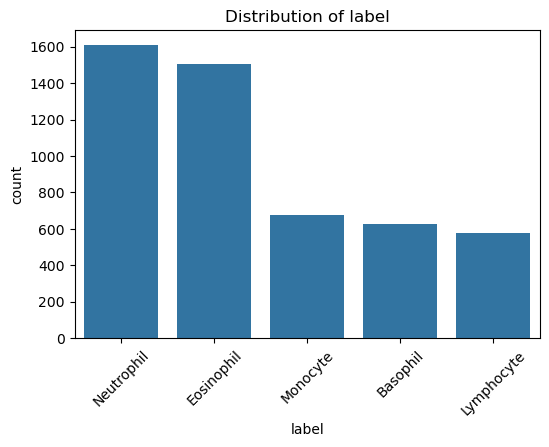

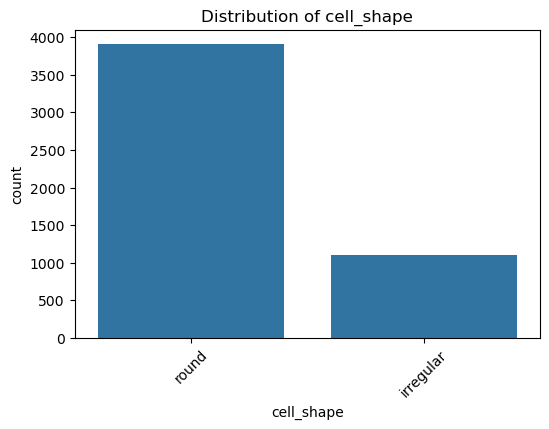

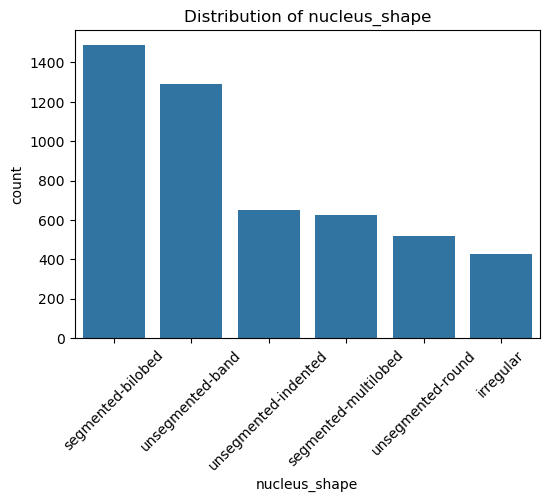

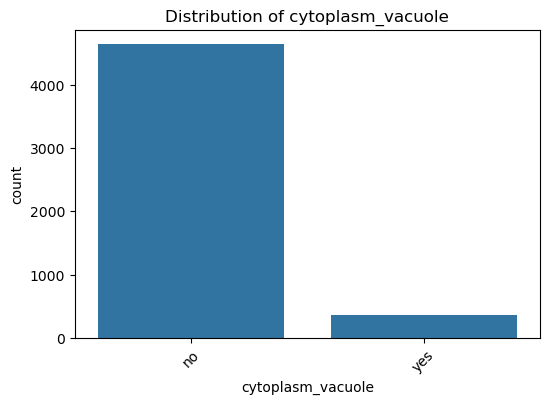

In [15]:
"""
class balance check, neutrophil and eosinophil has more distribution than other, have to take care of this.
round type shape is more
segmented and unsegmented is more
in cytoplasm vacuole, no has more data
"""

import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_labels, x=col, order=data_labels[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [16]:
# sizes = data_labels['Image'].apply(lambda img: img.size)
# print("Unique image shape and size:", sizes.value_counts())


from PIL import Image
from collections import Counter

size_counts = Counter()
for path in data_labels['full_path']:
    with Image.open(path) as img:
        size_counts[img.size] += 1

print("Unique image sizes and counts:", size_counts)


Unique image sizes and counts: Counter({(360, 363): 4875, (366, 369): 125})


In [17]:
import numpy as np
sample_path = data_labels['full_path'].iloc[0]
with Image.open(sample_path) as img:
    arr = np.array(img)
print("Pixel range:", arr.min(), "-", arr.max())
print("Shape:", arr.shape)


Pixel range: 24 - 255
Shape: (363, 360, 3)


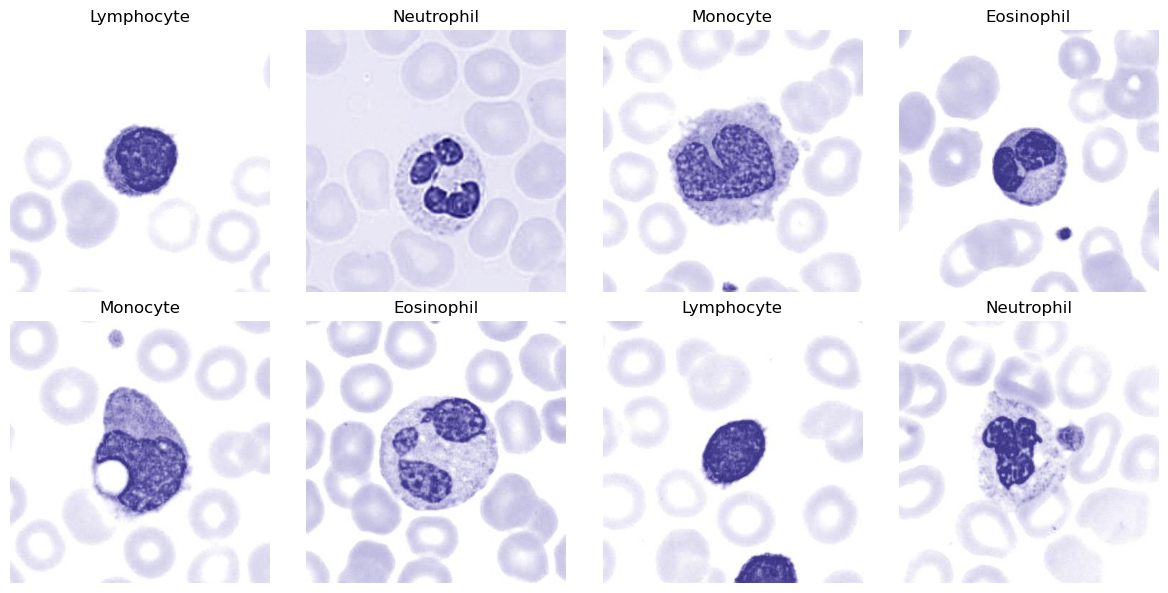

In [18]:
from random import sample

sample_paths = sample(list(data_labels['full_path']), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, path in zip(axes.flat, sample_paths):
    with Image.open(path) as img:
        ax.imshow(img)
    label = data_labels.loc[data_labels['full_path'] == path, 'label'].values[0]
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


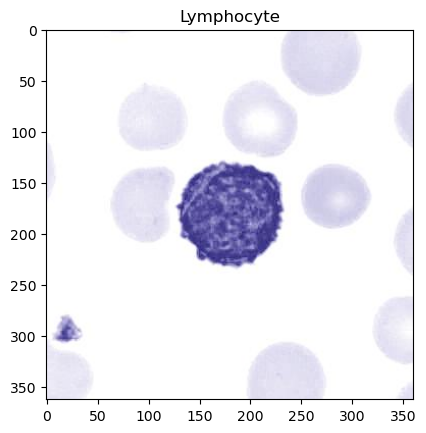

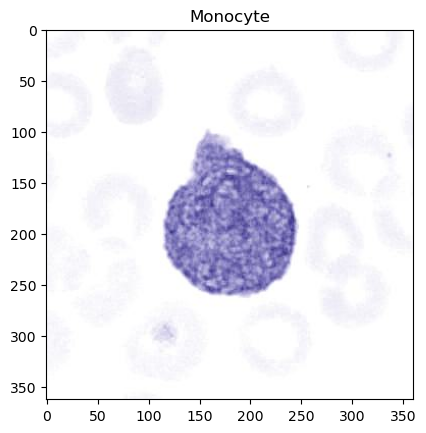

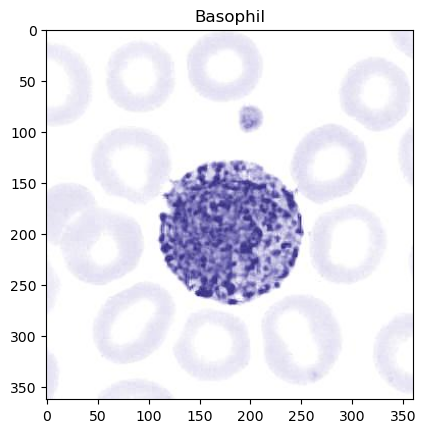

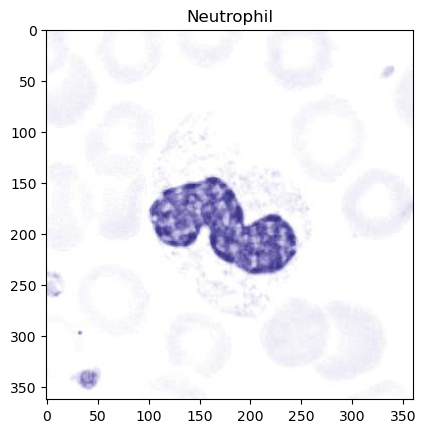

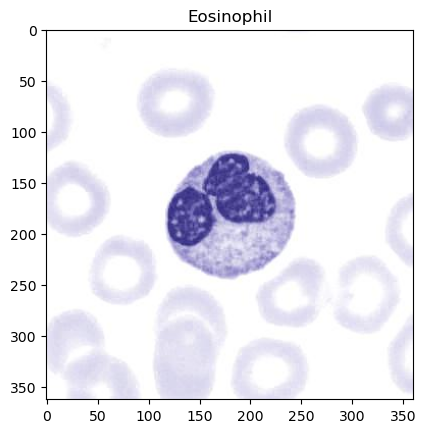

In [19]:
for cls in data_labels['label'].unique():
    sample_path = data_labels[data_labels['label'] == cls]['full_path'].sample(1).iloc[0]
    with Image.open(sample_path) as img:
        plt.imshow(img)
        plt.title(cls)
        plt.show()


In [20]:
# import numpy as np
# sample_img = np.array(data_labels['Image'].iloc[0])
# print("Pixel range:", sample_img.min(), "-", sample_img.max())
# print("Shape:", sample_img.shape)


In [21]:
# from random import sample

# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for ax, idx in zip(axes.flat, sample(range(len(data_labels)), 8)):
#     img = data_labels['Image'].iloc[idx]
#     label = data_labels['label'].iloc[idx]
#     ax.imshow(img)
#     ax.set_title(label)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()


In [22]:
# Statistical Analysis

# Look for:

# Distribution of resolutions

# Blurry or overcompressed images (e.g., using variance or edge detection)

# Corrupt or empty images
# check with blur detection in one batch

## Data loading, Merging with images preparing for training

In [23]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf

# TARGET_SIZE = (224, 224)  # good for transfer learning
# BATCH_SIZE  = 32
# AUTOTUNE    = tf.data.AUTOTUNE

# # Use pandas' Categorical to encode string labels → ints (stable & simple)
# for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
#     data_labels[col] = pd.Categorical(data_labels[col])
#     data_labels[col + '_idx'] = data_labels[col].cat.codes  # int labels starting at 0

# # Keep mapping dicts for later decoding (nice for reports/confusion matrices)
# idx2label = {i: c for i, c in enumerate(data_labels['label'].cat.categories)}
# idx2cell  = {i: c for i, c in enumerate(data_labels['cell_shape'].cat.categories)}
# idx2nuc   = {i: c for i, c in enumerate(data_labels['nucleus_shape'].cat.categories)}
# idx2vac   = {i: c for i, c in enumerate(data_labels['cytoplasm_vacuole'].cat.categories)}

# n_label = len(idx2label)
# n_cell  = len(idx2cell)
# n_nuc   = len(idx2nuc)
# n_vac   = len(idx2vac)

# print(n_label, n_cell, n_nuc, n_vac)




from sklearn.preprocessing import LabelEncoder



TARGET_SIZE = (224, 224)  # good for transfer learning
# TARGET_SIZE = (360, 360) 
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
cell_encoder  = LabelEncoder()
nuc_encoder   = LabelEncoder()
vac_encoder   = LabelEncoder()

data_labels['label_idx'] = label_encoder.fit_transform(data_labels['label'])
data_labels['cell_shape_idx'] = cell_encoder.fit_transform(data_labels['cell_shape'])
data_labels['nucleus_shape_idx'] = nuc_encoder.fit_transform(data_labels['nucleus_shape'])
data_labels['cytoplasm_vacuole_idx'] = vac_encoder.fit_transform(data_labels['cytoplasm_vacuole'])

# Store category names
n_label = len(label_encoder.classes_)
n_cell  = len(cell_encoder.classes_)
n_nuc   = len(nuc_encoder.classes_)
n_vac   = len(vac_encoder.classes_)

print(n_label, n_cell, n_nuc, n_vac)

5 2 6 2


In [24]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data_labels,
    test_size=0.2,
    random_state=42,
    stratify=data_labels['label_idx']  # stratify on main class
)

len(train_df), len(val_df)


(4000, 1000)

In [25]:
def oversample_minority_classes(df, label_col='label_idx'):
    class_counts = df[label_col].value_counts()
    target_count = class_counts.max()

    oversampled_parts = []

    for cls, count in class_counts.items():
        df_cls = df[df[label_col] == cls]
        reps = target_count // count
        rem = target_count % count

        df_oversampled = pd.concat(
            [df_cls] * reps + [df_cls.sample(rem, replace=True)],
            ignore_index=True
        )
        oversampled_parts.append(df_oversampled)

    # Combine and shuffle
    df_balanced = pd.concat(oversampled_parts, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42)
    return df_balanced


In [26]:
train_df_balanced = oversample_minority_classes(train_df)
print("Before:", train_df['label_idx'].value_counts().to_dict())
print("After:", train_df_balanced['label_idx'].value_counts().to_dict())


Before: {4: 1288, 1: 1203, 3: 543, 0: 503, 2: 463}
After: {0: 1288, 1: 1288, 3: 1288, 4: 1288, 2: 1288}


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = 42
val_df = val_df.copy()  # just in case

# ---- 1) build a small EYEBALL set: per-class k samples ----
per_class = 10  # tweak: 8–12 is typical
eyeball_idx = []

for cls, group in val_df.groupby('label_idx'):
    take = group.sample(n=min(per_class, len(group)), random_state=rng).index
    eyeball_idx.append(take)

eyeball_idx = np.concatenate(eyeball_idx) if len(eyeball_idx) else np.array([], dtype=int)
eyeball_df  = val_df.loc[eyeball_idx].copy()

# remaining = blackbox candidate pool
blackbox_pool = val_df.drop(index=eyeball_idx)

# ---- 2) optionally keep blackbox to a fixed fraction of the whole val ----
# e.g., use all remaining (recommended) or take a fraction stratified
# here we keep ALL remaining:
blackbox_df = blackbox_pool.copy()

print({
    "eyeball_dev": len(eyeball_df),
    "blackbox_dev": len(blackbox_df)
})

# quick sanity
print("Eyeball per class:\n", eyeball_df['label'].value_counts())
print("Blackbox per class:\n", blackbox_df['label'].value_counts())


{'eyeball_dev': 50, 'blackbox_dev': 950}
Eyeball per class:
 label
Basophil      10
Eosinophil    10
Lymphocyte    10
Monocyte      10
Neutrophil    10
Name: count, dtype: int64
Blackbox per class:
 label
Neutrophil    312
Eosinophil    291
Monocyte      126
Basophil      115
Lymphocyte    106
Name: count, dtype: int64


In [28]:
# You're using LabelEncoder because:

# Your labels are categorical text.

# You need to convert them into numeric format to be compatible with TensorFlow/Keras or any ML model.

# You store the number of classes with n_label, n_cell, etc., which is useful for building final dense layers or loss functions.

In [29]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def cls_weights(y_int, n_classes):
    classes = np.arange(n_classes)
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_int)
    return w.astype(np.float32)  # numpy array

W_LABEL = cls_weights(train_df['label_idx'].values,             n_label)
W_CELL  = cls_weights(train_df['cell_shape_idx'].values,        n_cell)
W_NUC   = cls_weights(train_df['nucleus_shape_idx'].values,     n_nuc)
W_VAC   = cls_weights(train_df['cytoplasm_vacuole_idx'].values, n_vac)


In [30]:
# balance on this head
MAIN_KEY    = "out_label"
NUM_CLASSES = n_label

def _class_from_onehot(x, labels):
    return tf.argmax(labels[MAIN_KEY], axis=-1, output_type=tf.int32)

# convert one-hot to ids (works on batched tensors too)
def _onehot_id(t): 
    return tf.argmax(t, axis=-1, output_type=tf.int32)

# Attach per-head sample weights
W_LABEL_T = tf.constant(W_LABEL)
W_CELL_T  = tf.constant(W_CELL)
W_NUC_T   = tf.constant(W_NUC)
W_VAC_T   = tf.constant(W_VAC)

def attach_weights(x, y):
    cid_label = _onehot_id(y['out_label'])
    cid_cell  = _onehot_id(y['out_cell'])
    cid_nuc   = _onehot_id(y['out_nuc'])
    cid_vac   = _onehot_id(y['out_vac'])

    sw = {
        # 'out_label': tf.gather(W_LABEL_T, cid_label),
        'out_cell':  tf.gather(W_CELL_T,  cid_cell),
        'out_nuc':   tf.gather(W_NUC_T,   cid_nuc),
        'out_vac':   tf.gather(W_VAC_T,   cid_vac),
    }
    return x, y, sw


2025-08-30 09:39:53.064570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-30 09:39:53.067950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-30 09:39:53.070542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
def load_and_preprocess(path, y_label, y_cell, y_nuc, y_vac):
    # path: tf.string, labels: tf.int32
    img = tf.io.read_file(path)
    # use decode_jpeg or decode_image (handles png/jpg). You have .jpg, so:
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # img = tf.cast(img, tf.float32)

    # Optionally do light augmentation for training via a separate map
    labels = {
        'out_label': tf.one_hot(y_label, depth=n_label),
        'out_cell':  tf.one_hot(y_cell,  depth=n_cell),
        'out_nuc':   tf.one_hot(y_nuc,   depth=n_nuc),
        'out_vac':   tf.one_hot(y_vac,   depth=n_vac),
    }
    return img, labels

def make_dataset(df, shuffle=False, augment=False, add_weights=False, repeat=False):
    paths = df['full_path'].astype(str).values
    y_label = df['label_idx'].values.astype(np.int32)
    y_cell  = df['cell_shape_idx'].values.astype(np.int32)
    y_nuc   = df['nucleus_shape_idx'].values.astype(np.int32)
    y_vac   = df['cytoplasm_vacuole_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_cell, y_nuc, y_vac))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=42)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
            # tf.keras.layers.RandomBrightness(factor=0.1),
            tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),
            # tf.keras.layers.Rescaling(1./255),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    if repeat:
        ds = ds.repeat()

        # === Step 5: Optional weighting ===
    if add_weights:
        ds = ds.map(attach_weights, num_parallel_calls=AUTOTUNE)

    ds = ds.prefetch(AUTOTUNE)
    return ds

In [32]:
train_ds    = make_dataset(train_df_balanced, shuffle=True, augment=True, repeat=True, add_weights=False )     # repeated
eyeball_ds  = make_dataset(eyeball_df, shuffle=False, augment=False, repeat=False) # NOT repeated
blackbox_ds = make_dataset(blackbox_df, shuffle=False, augment=False, repeat=False) # NOT repeated

In [33]:
for imgs, labels in train_ds.take(1):
    print("imgs:", imgs.shape, imgs.dtype, tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    for k, v in labels.items():
        v = tf.cast(v, tf.float32)
        print(k, v.shape, "one-hot sums per row ~1:",
              tf.reduce_mean(tf.reduce_sum(v, axis=1)).numpy())


imgs: (32, 224, 224, 3) <dtype: 'float32'> 0.08193858 1.0
out_label (32, 5) one-hot sums per row ~1: 1.0
out_cell (32, 2) one-hot sums per row ~1: 1.0
out_nuc (32, 6) one-hot sums per row ~1: 1.0
out_vac (32, 2) one-hot sums per row ~1: 1.0


2025-08-30 09:40:09.580836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


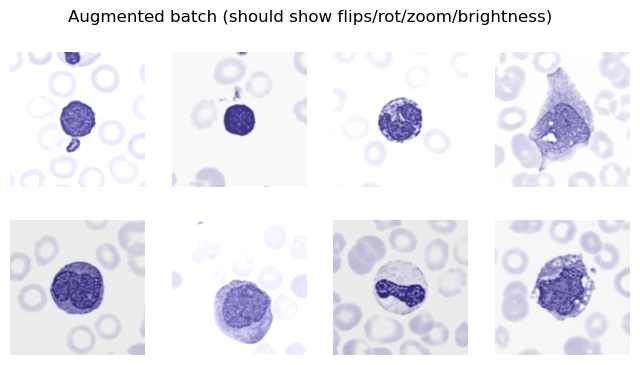

2025-08-30 09:40:10.217531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
import matplotlib.pyplot as plt

def show_batch(imgs, rows=2, cols=4, title=""):
    imgs = imgs.numpy()
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(min(len(imgs), rows*cols)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        ax.axis('off')
    if title: plt.suptitle(title)
    plt.show()

for imgs, labels in train_ds.take(1):
    show_batch(imgs, title="Augmented batch (should show flips/rot/zoom/brightness)")


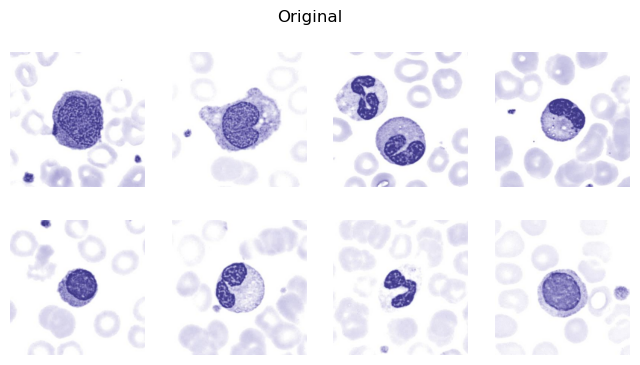

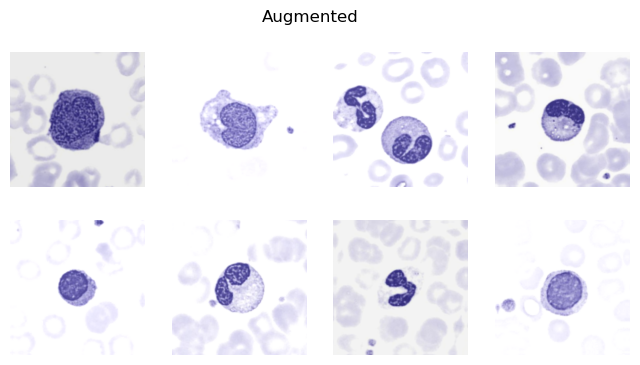

Per-image mean abs diffs: [0.10051125 0.04381777 0.08996662 0.07286356 0.03985592 0.04534821
 0.0601581  0.03778525]


In [35]:
subset = train_df.sample(8, random_state=123)

noaug = make_dataset(subset, shuffle=False, augment=False, repeat=False)
aug   = make_dataset(subset, shuffle=False, augment=True,  repeat=False)

paired = tf.data.Dataset.zip((noaug, aug)).take(1)
(orig_imgs, _), (aug_imgs, _) = next(iter(paired))

show_batch(orig_imgs, title="Original")
show_batch(aug_imgs,  title="Augmented")

# Quantify difference per image (should be >0 for most)
diff = tf.reduce_mean(tf.abs(tf.cast(orig_imgs, tf.float32) - tf.cast(aug_imgs, tf.float32)), axis=[1,2,3])
print("Per-image mean abs diffs:", diff.numpy())


In [36]:
xb, yb = next(iter(train_ds))
print("Batch images:", xb.shape)  # (B, 224, 224, 3)
for k, v in yb.items():
    print(k, v.shape)             # one-hot shapes per head


Batch images: (32, 224, 224, 3)
out_label (32, 5)
out_cell (32, 2)
out_nuc (32, 6)
out_vac (32, 2)


## Model Evaluation Helper function

In [37]:
import re, matplotlib.pyplot as plt

def plot_history(history, save_dir=None):
    h = history.history

    # discover heads from keys like "out_label_accuracy", "out_label_loss"
    heads = sorted({m.group(1) for k in h.keys()
                    if (m := re.match(r'^(out_[^_]+)_(accuracy|loss)$', k))})

    # --- Accuracy ---
    plt.figure()
    for head in heads:
        acc_key = f"{head}_accuracy"
        val_key = f"val_{head}_accuracy"
        if acc_key in h: plt.plot(h[acc_key], label=f"{head} acc")
        if val_key in h: plt.plot(h[val_key], linestyle='--', label=f"val {head} acc")
    plt.title("Per-head Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/acc.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- Loss (per head + total) ---
    plt.figure()
    for head in heads:
        loss_key = f"{head}_loss"
        val_loss_key = f"val_{head}_loss"
        if loss_key in h: plt.plot(h[loss_key], label=f"{head} loss")
        if val_loss_key in h: plt.plot(h[val_loss_key], linestyle='--', label=f"val {head} loss")
    if "loss" in h: plt.plot(h["loss"], label="total loss")
    if "val_loss" in h: plt.plot(h["val_loss"], linestyle='--', label="val total loss")
    plt.title("Per-head Loss (and Total)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/loss.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- (Optional) Learning rate if ReduceLROnPlateau/SGD schedules add 'lr' ---
    if "lr" in h:
        plt.figure()
        plt.plot(h["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("lr")
        plt.grid(True)
        if save_dir: plt.savefig(f"{save_dir}/lr.png", dpi=150, bbox_inches='tight')
        plt.show()


In [38]:
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def _onehot_to_idx(y):
    if y.ndim == 2:
        return np.argmax(y, axis=1)
    return y

def evaluate_heads_with_reports(model, dataset, head_names=None, class_names_map=None, save_dir=None, normalize_cm=False):
    """
    model: tf.keras.Model with dict outputs like {'out_label': ..., ...}
    dataset: tf.data.Dataset yielding (x, {'out_label': onehot, ...})
    """
    # --- ensure output folder exists if requested ---
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    y_true_dict, y_pred_dict = {}, {}

    # Discover heads if not provided
    if head_names is None:
        for _, y in dataset.take(1):
            head_names = sorted(list(y.keys()))

    for h in head_names:
        y_true_dict[h], y_pred_dict[h] = [], []

    for xb, yb in dataset:
        preds = model(xb, training=False)
        if not isinstance(preds, dict):
            preds = {h: p for h, p in zip(head_names, preds)}

        for h in head_names:
            y_true_dict[h].append(_onehot_to_idx(yb[h].numpy()))
            y_pred_dict[h].append(np.argmax(preds[h].numpy(), axis=1))

    # Concatenate and report
    for h in head_names:
        y_true = np.concatenate(y_true_dict[h], axis=0)
        y_pred = np.concatenate(y_pred_dict[h], axis=0)
        target_names = class_names_map.get(h) if class_names_map else None

        print(f"\n===== Classification report for {h} =====")
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        cm = confusion_matrix(y_true, y_pred, normalize=normalize_cm if normalize_cm else None)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names if target_names else None)
        plt.figure()
        disp.plot(values_format=".2f" if normalize_cm else "d", xticks_rotation=45, colorbar=True)
        plt.title(f"{h} — Confusion Matrix" + (f" (normalized: {normalize_cm})" if normalize_cm else ""))
        plt.tight_layout()
        if save_dir:
            norm_tag = f"_norm-{normalize_cm}" if normalize_cm else ""
            out_path = save_dir / f"cm_{h}{norm_tag}.png"
            plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.show()


In [39]:
class_names_map = {
    'out_label': label_encoder.classes_.tolist(),
    'out_cell':  cell_encoder.classes_.tolist(),
    'out_nuc':   nuc_encoder.classes_.tolist(),
    'out_vac':   vac_encoder.classes_.tolist(),
}

for name, enc in [('out_label', label_encoder),
                  ('out_cell',  cell_encoder),
                  ('out_nuc',   nuc_encoder),
                  ('out_vac',   vac_encoder)]:
    print(f"{name} mapping:")
    for i, cls in enumerate(enc.classes_):
        print(f"  {i} → {cls}")


out_label mapping:
  0 → Basophil
  1 → Eosinophil
  2 → Lymphocyte
  3 → Monocyte
  4 → Neutrophil
out_cell mapping:
  0 → irregular
  1 → round
out_nuc mapping:
  0 → irregular
  1 → segmented-bilobed
  2 → segmented-multilobed
  3 → unsegmented-band
  4 → unsegmented-indented
  5 → unsegmented-round
out_vac mapping:
  0 → no
  1 → yes


## Baseline Model

In [ ]:
"""

Baseline. We adopt a VGG16 (ImageNet-pretrained) baseline with a frozen convolutional backbone and a lightweight classifier head. Tsutsui et al.
established reproducible WBC baselines and showed that VGG-style CNNs are robust under domain shift, often outperforming ResNets when imaging conditions change. 
We therefore use VGG16 as a simple, standard, and comparable baseline for PBC.

Minimal baseline spec (to mirror your multi-head model)

Model: tf.keras.applications.VGG16(include_top=False, weights="imagenet"), trainable=False; GAP → Dense(256, ReLU, Dropout 0.5) → your four softmax heads (out_label, out_cell, out_nuc, out_vac).

Input/Norm: 224×224; use tf.keras.applications.vgg16.preprocess_input.

Train: Adam(1e-3), ReduceLROnPlateau, EarlyStopping; 10–20 epochs. (Optional) unfreeze last conv block and fine-tune 5–10 epochs with lr=1e-5.


Minimal baseline spec (to mirror your multi-head model)

Model: tf.keras.applications.VGG16(include_top=False, weights="imagenet"), trainable=False; GAP → Dense(256, ReLU, Dropout 0.5) → your four softmax heads (out_label, out_cell, out_nuc, out_vac).

Input/Norm: 224×224; use tf.keras.applications.vgg16.preprocess_input.

Train: Adam(1e-3), ReduceLROnPlateau, EarlyStopping; 10–20 epochs. (Optional) unfreeze last conv block and fine-tune 5–10 epochs with lr=1e-5.


"""

In [48]:
import tensorflow as tf
import math

# sizes from your setup
n_label, n_cell, n_nuc, n_vac = n_label, n_cell, n_nuc, n_vac  # already defined in your code

def vgg16_baseline_multihead():
    base = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                       input_shape=(360,360,3))
    base.trainable = False  # Phase 1: frozen

    inputs = tf.keras.Input(shape=(360,360,3))
    # choose ONE normalization style; if you pick this, don't also /255.0 in the pipeline
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    out_label = tf.keras.layers.Dense(n_label, activation="softmax", name="out_label")(x)
    out_cell  = tf.keras.layers.Dense(n_cell,  activation="softmax", name="out_cell")(x)
    out_nuc   = tf.keras.layers.Dense(n_nuc,   activation="softmax", name="out_nuc")(x)
    out_vac   = tf.keras.layers.Dense(n_vac,   activation="softmax", name="out_vac")(x)

    return tf.keras.Model(inputs, {"out_label": out_label,
                                   "out_cell":  out_cell,
                                   "out_nuc":   out_nuc,
                                   "out_vac":   out_vac})

model_base = vgg16_baseline_multihead()
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "out_label": "categorical_crossentropy",
        "out_cell":  "categorical_crossentropy",
        "out_nuc":   "categorical_crossentropy",
        "out_vac":   "categorical_crossentropy",
    },
    metrics=["accuracy"]
)

BATCH_SIZE = 32
steps_per_epoch   = math.ceil(len(train_df) / BATCH_SIZE)
validation_steps  = math.ceil(len(val_df)   / BATCH_SIZE)




# Phase 1: train heads only
history_base = model_base.fit(train_ds,
                         steps_per_epoch = steps_per_epoch,
                         validation_data=blackbox_ds, 
                         epochs=15,
                    callbacks=[
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
                    ])

# # # (Optional) Phase 2: fine-tune last conv block for a few epochs
# # for layer in model_base.layers[1].layers:  # model.layers[1] is base VGG
# #     layer.trainable = False
# # for layer in model_base.layers[1].layers[-4*3:]:  # roughly the last conv block
# #     layer.trainable = True

# model_base.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss=model.loss, metrics=model.metrics)

# history_base = model_base.fit(train_ds, validation_data=blackbox_ds, epochs=5)

Epoch 1/15
125/125 [==============================] - 152s 1s/step - loss: 4.7167 - out_cell_loss: 0.6092 - out_label_loss: 1.7517 - out_nuc_loss: 1.9557 - out_vac_loss: 0.4002 - out_cell_accuracy: 0.7140 - out_label_accuracy: 0.2062 - out_nuc_accuracy: 0.1943 - out_vac_accuracy: 0.8665 - val_loss: 4.1239 - val_out_cell_loss: 0.5222 - val_out_label_loss: 1.5959 - val_out_nuc_loss: 1.7506 - val_out_vac_loss: 0.2552 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3284 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 147s 1s/step - loss: 4.3551 - out_cell_loss: 0.5842 - out_label_loss: 1.6279 - out_nuc_loss: 1.7929 - out_vac_loss: 0.3501 - out_cell_accuracy: 0.7379 - out_label_accuracy: 0.1967 - out_nuc_accuracy: 0.2015 - out_vac_accuracy: 0.8991 - val_loss: 4.1738 - val_out_cell_loss: 0.5396 - val_out_label_loss: 1.6135 - val_out_nuc_loss: 1.7594 - val_out_vac_loss: 0.2613 - val_out_cell_accuracy:

## Baseline Evaluation

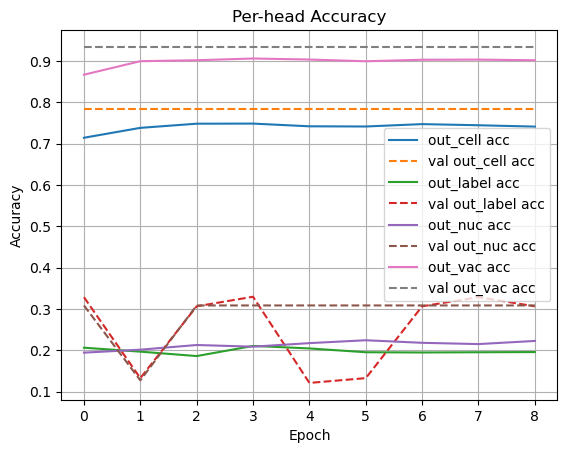

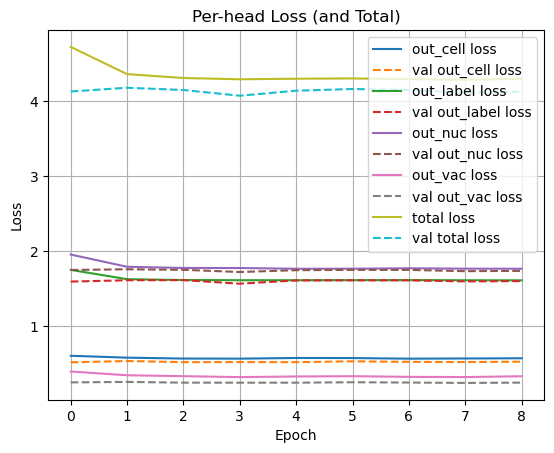

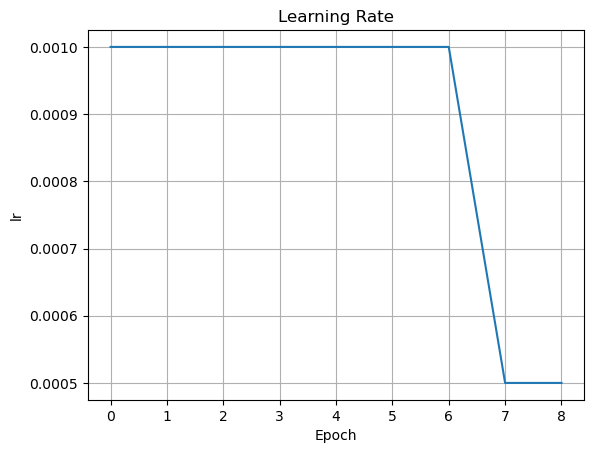

In [49]:
plot_history(history_base)

2025-08-26 09:22:25.732001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 09:22:40.080986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


===== Classification report for out_cell =====
              precision    recall  f1-score   support

   irregular     0.0000    0.0000    0.0000       205
       round     0.7842    1.0000    0.8791       745

    accuracy                         0.7842       950
   macro avg     0.3921    0.5000    0.4395       950
weighted avg     0.6150    0.7842    0.6894       950



<Figure size 640x480 with 0 Axes>

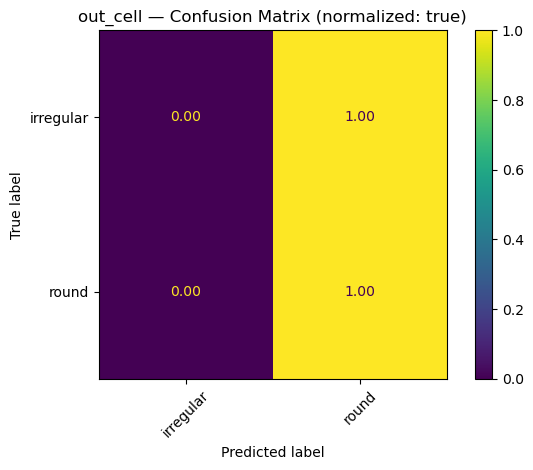


===== Classification report for out_label =====
              precision    recall  f1-score   support

    Basophil     0.0000    0.0000    0.0000       115
  Eosinophil     0.3333    0.0103    0.0200       291
  Lymphocyte     0.0000    0.0000    0.0000       106
    Monocyte     0.0000    0.0000    0.0000       126
  Neutrophil     0.3294    0.9936    0.4948       312

    accuracy                         0.3295       950
   macro avg     0.1326    0.2008    0.1030       950
weighted avg     0.2103    0.3295    0.1686       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

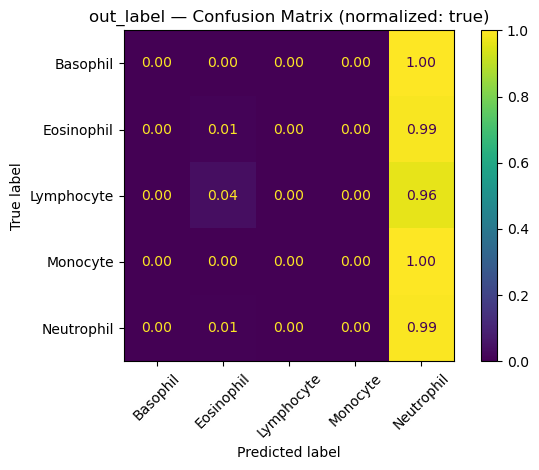


===== Classification report for out_nuc =====
                      precision    recall  f1-score   support

           irregular     0.0000    0.0000    0.0000        76
   segmented-bilobed     0.3084    1.0000    0.4714       293
segmented-multilobed     0.0000    0.0000    0.0000       117
    unsegmented-band     0.0000    0.0000    0.0000       248
unsegmented-indented     0.0000    0.0000    0.0000       121
   unsegmented-round     0.0000    0.0000    0.0000        95

            accuracy                         0.3084       950
           macro avg     0.0514    0.1667    0.0786       950
        weighted avg     0.0951    0.3084    0.1454       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

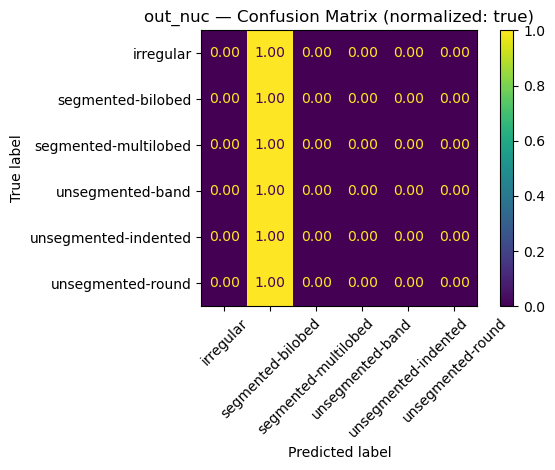


===== Classification report for out_vac =====
              precision    recall  f1-score   support

          no     0.9337    1.0000    0.9657       887
         yes     0.0000    0.0000    0.0000        63

    accuracy                         0.9337       950
   macro avg     0.4668    0.5000    0.4829       950
weighted avg     0.8718    0.9337    0.9017       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

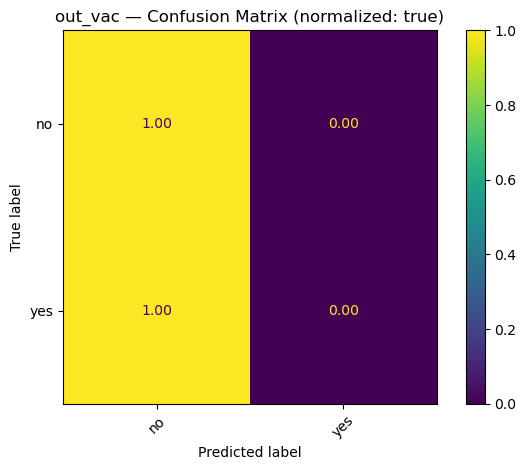

In [50]:
evaluate_heads_with_reports(
    model_base,
    blackbox_ds,                 # or test_dataset
    class_names_map=class_names_map,
    save_dir="./metrics_plots",  # optional: saves PNGs
    normalize_cm='true'          # 'true'|'pred'|'all' or False
)

## Final Model

In [52]:

# # Main model to pivot

# import tensorflow as tf

# class WbcModel(tf.keras.Model):
#     def __init__(self, num_classes = 4):
#         super().__init__()

#         #layer1
#         self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
#         self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #layer2
#         self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
#         self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #Layer3
#         self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')
#         self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#          #Layer4
#         self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')
#         self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)


#         #Regularization
#         self.drop = tf.keras.layers.Dropout(0.25)

#         #Head, 4 for this problem
#         # self.flat = tf.keras.layers.Flatten()

#         self.gap = tf.keras.layers.GlobalAveragePooling2D()

        
#         self.out_label = tf.keras.layers.Dense(n_label, activation='softmax',name='out_label')
#         self.out_cell = tf.keras.layers.Dense(n_cell, activation='softmax',name='out_cell')
#         self.out_nuc = tf.keras.layers.Dense(n_nuc,activation='softmax',name='out_nuc')
#         self.out_vac = tf.keras.layers.Dense(n_vac,activation='softmax',name='out_vac')

#     def call(self,x, training=False):
#         x = self.conv1(x); x = self.pool1(x)
#         x = self.conv2(x); x = self.pool2(x)
#         x = self.conv3(x); x = self.pool3(x)
#         x = self.conv4(x); x = self.pool4(x)
        

#         if training:
#             x = self.drop(x)

#         # x = self.flat(x)
#         x = self.gap(x)

#         if training:
#             x = self.drop(x)

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# model = WbcModel(num_classes=4)

# model.build(input_shape=(None,224,224,3))
# model.summary()
        

        

In [51]:

# # Test -1 

# import tensorflow as tf

# from tensorflow.keras import layers, initializers



# class WbcModel(tf.keras.Model):
#     def __init__(self, num_classes = 4):
#         super().__init__()

#         #layer1
#         self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #layer2
#         self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         #Layer3
#         self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#          #Layer4
#         self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu',kernel_initializer=initializers.HeNormal())
#         self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)


#         #Regularization
#         self.drop = tf.keras.layers.Dropout(0.25)

#         #Head, 4 for this problem
#         # self.flat = tf.keras.layers.Flatten()

#         self.gap = tf.keras.layers.GlobalAveragePooling2D()

        
#         self.out_label = tf.keras.layers.Dense(n_label, activation='softmax',name='out_label')
#         self.out_cell = tf.keras.layers.Dense(n_cell, activation='softmax',name='out_cell')
#         self.out_nuc = tf.keras.layers.Dense(n_nuc,activation='softmax',name='out_nuc')
#         self.out_vac = tf.keras.layers.Dense(n_vac,activation='softmax',name='out_vac')

#     def call(self,x, training=False):
#         x = self.conv1(x); x = self.pool1(x)
#         x = self.conv2(x); x = self.pool2(x)
#         x = self.conv3(x); x = self.pool3(x)
#         x = self.conv4(x); x = self.pool4(x)
        

#         if training:
#             x = self.drop(x)

#         # x = self.flat(x)
#         x = self.gap(x)

#         if training:
#             x = self.drop(x)

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# model = WbcModel(num_classes=4)

# model.build(input_shape=(None,224,224,3))
# model.summary()
        

        

In [49]:
# #test- 3

# import tensorflow as tf
# from tensorflow.keras import layers, initializers

# class VggWbcModel(tf.keras.Model):
#     def __init__(self, n_label, n_cell, n_nuc, n_vac):
#         super().__init__()

#         he = initializers.HeNormal()

#         # --- Block 1 (64) ---
#         self.conv11 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv12 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool1  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 2 (128) ---
#         self.conv21 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv22 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool2  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 3 (256) ---
#         self.conv31 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv32 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool3  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Block 4 (256) (kept lighter than classic VGG) ---
#         self.conv41 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.conv42 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=he)
#         self.pool4  = layers.MaxPool2D(pool_size=2, strides=2)

#         # --- Classifier head (VGG-style) ---
#         self.flatten = layers.Flatten()
#         self.fc1     = layers.Dense(512, activation='relu', kernel_initializer=he)
#         self.drop    = layers.Dropout(0.5)

#         # --- Outputs (4 heads) ---
#         self.out_label = layers.Dense(n_label, activation='softmax', name='out_label')
#         self.out_cell  = layers.Dense(n_cell,  activation='softmax', name='out_cell')
#         self.out_nuc   = layers.Dense(n_nuc,   activation='softmax', name='out_nuc')
#         self.out_vac   = layers.Dense(n_vac,   activation='softmax', name='out_vac')

#     def call(self, x, training=False):
#         # Block 1
#         x = self.conv11(x); x = self.conv12(x); x = self.pool1(x)
#         # Block 2
#         x = self.conv21(x); x = self.conv22(x); x = self.pool2(x)
#         # # Block 3
#         # x = self.conv31(x); x = self.conv32(x); x = self.pool3(x)
#         # # Block 4
#         # x = self.conv41(x); x = self.conv42(x); x = self.pool4(x)

#         # Classifier
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.drop(x, training=training)   # active only during training

#         return {
#             "out_label": self.out_label(x),
#             "out_cell":  self.out_cell(x),
#             "out_nuc":   self.out_nuc(x),
#             "out_vac":   self.out_vac(x)
#         }

# # --- build & summary (keeps your style) ---
# model = VggWbcModel(n_label, n_cell, n_nuc, n_vac)
# model.build(input_shape=(None, 224, 224, 3))
# model.summary()


In [35]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss={
#         'out_label': 'categorical_crossentropy',
#         'out_cell':  'categorical_crossentropy',
#         'out_nuc':   'categorical_crossentropy',
#         'out_vac':   'categorical_crossentropy',
#     },
#     loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
# )

## Model with hyper parameter tunning capability 

In [53]:
# =========================
# 1) Model with knobs
# =========================
import tensorflow as tf
from tensorflow.keras import regularizers

class WbcModel(tf.keras.Model):
    def __init__(self,
                 n_label, n_cell, n_nuc, n_vac,
                 filters_scale=1.0,
                 kernel_size=3,
                 dropout=0.25,
                 l2=0.0):
        super().__init__()
        reg = regularizers.l2(l2) if l2 and l2 > 0 else None
        k   = int(kernel_size)
        fs  = float(filters_scale)

        # Conv blocks (scaled filters, tunable kernel size + L2)
        self.conv1 = tf.keras.layers.Conv2D(int(32*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv2 = tf.keras.layers.Conv2D(int(64*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv3 = tf.keras.layers.Conv2D(int(128*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv4 = tf.keras.layers.Conv2D(int(256*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.drop = tf.keras.layers.Dropout(dropout)
        self.gap  = tf.keras.layers.GlobalAveragePooling2D()

        # Multi-head outputs (unchanged)
        self.out_label = tf.keras.layers.Dense(n_label, activation='softmax', name='out_label')
        self.out_cell  = tf.keras.layers.Dense(n_cell,  activation='softmax', name='out_cell')
        self.out_nuc   = tf.keras.layers.Dense(n_nuc,   activation='softmax', name='out_nuc')
        self.out_vac   = tf.keras.layers.Dense(n_vac,   activation='softmax', name='out_vac')

    def call(self, x, training=False):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        if training: x = self.drop(x)
        x = self.gap(x)
        if training: x = self.drop(x)
        return {
            "out_label": self.out_label(x),
            "out_cell":  self.out_cell(x),
            "out_nuc":   self.out_nuc(x),
            "out_vac":   self.out_vac(x)
        }

# (optional) quick build check
m = WbcModel(n_label, n_cell, n_nuc, n_vac); m.build((None,224,224,3)); m.summary()


Model: "wbc_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          multiple                  896       
                                                                 
 max_pooling2d_8 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          multiple                  18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          multiple                  73856     
                                                                 
 max_pooling2d_10 (MaxPooli  multiple                  

## Hyper parameter tunning

In [58]:
# =========================
# 2) F1 evaluator for val set
# =========================
from sklearn.metrics import f1_score
import numpy as np

def evaluate_f1_on_val(model, val_ds, head="out_label"):
    """Computes F1-macro and F1-weighted over the validation dataset for a single head."""
    y_true, y_pred = [], []
    for x, y in val_ds:
        preds = model.predict(x, verbose=0)          # dict of heads
        pred_ids = np.argmax(preds[head], axis=1)     # predicted classes
        true_ids = np.argmax(y[head], axis=1)         # true classes (one-hot -> ids)
        y_pred.extend(pred_ids)
        y_true.extend(true_ids)
    f1_macro    = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    return f1_macro, f1_weighted


In [59]:
# =========================
# 3) Tuning harness (A1 LR → B1 Dropout → B2 L2 → C1 Kernel)
# =========================
import csv, tensorflow as tf
tf.random.set_seed(42)

RESULTS_CSV = "tuning_results.csv"
FIXED_BATCH = 32  # just for naming clarity (datasets unchanged)

def make_model(hp):
    """Factory for a model using hyperparameters dict hp."""
    m = WbcModel(
        n_label=n_label, n_cell=n_cell, n_nuc=n_nuc, n_vac=n_vac,
        filters_scale=hp.get("filters_scale", 1.0),
        kernel_size=hp.get("kernel_size", 3),
        dropout=hp.get("dropout", 0.25),
        l2=hp.get("l2", 0.0)
    )
    m.build(input_shape=(None,224,224,3))
    return m

def run_trial(hp, tag):
    """Train one trial and return (val_acc_best, f1_macro, f1_weighted, run_name)."""
    lr  = float(hp["lr"])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    run_name = (
        f"{tag}_lr{lr}_bs{FIXED_BATCH}_do{hp.get('dropout',0.25)}_l2{hp.get('l2',0.0)}"
        + (f"_ks{hp['kernel_size']}" if 'kernel_size' in hp else "")
    ).replace(".","p")

    # Build model once, then fit so we can evaluate the trained instance
    model = make_model(hp)
    hist = compile_and_fit(
        model=model,
        name=run_name,
        optimizer=opt,
        max_epochs=MAX_EPOCH
    )

    # Best validation accuracy (from training logs)
    val_acc_best = float(max(hist.history.get("val_out_label_accuracy", [0.0])))

    # Validation F1 scores on the same trained model
    f1_macro, f1_weighted = evaluate_f1_on_val(model, blackbox_ds, head="out_label")

    return val_acc_best, f1_macro, f1_weighted, run_name

# ---- collect results here
results = []

# -------- Phase A1 — LR sweep --------
A1_space  = [{"lr": v} for v in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]]
A1_scores = []
for hp in A1_space:
    acc, f1m, f1w, run = run_trial(hp, "A1")
    A1_scores.append((f1m, hp))
    results.append({
        "phase":"A1", "lr":hp["lr"], "dropout":None, "l2":None, "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_lr = max(A1_scores, key=lambda t: t[0])[1]["lr"]

# -------- Phase B1 — Dropout sweep (hold best LR) --------
B1_space  = [{"lr":best_lr, "dropout":d} for d in [0.2, 0.3, 0.5]]
B1_scores = []
for hp in B1_space:
    acc, f1m, f1w, run = run_trial(hp, "B1")
    B1_scores.append((f1m, hp))
    results.append({
        "phase":"B1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":None, "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_do = max(B1_scores, key=lambda t: t[0])[1]["dropout"]

# -------- Phase B2 — L2 sweep (hold best LR & Dropout) --------
B2_space  = [{"lr":best_lr, "dropout":best_do, "l2":l2} for l2 in [0.0, 1e-4, 1e-3]]
B2_scores = []
for hp in B2_space:
    acc, f1m, f1w, run = run_trial(hp, "B2")
    B2_scores.append((f1m, hp))
    results.append({
        "phase":"B2", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":None,
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_l2 = max(B2_scores, key=lambda t: t[0])[1]["l2"]

# -------- Phase C1 — Kernel size sweep --------
C1_space  = [{"lr":best_lr, "dropout":best_do, "l2":best_l2, "kernel_size":k} for k in [3, 5]]
C1_scores = []
for hp in C1_space:
    acc, f1m, f1w, run = run_trial(hp, "C1")
    C1_scores.append((f1m, hp))
    results.append({
        "phase":"C1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":hp["kernel_size"],
        "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
    })
best_kernel = max(C1_scores, key=lambda t: t[0])[1]["kernel_size"]

# Final chosen HPs
best_hp = {"lr": best_lr, "dropout": best_do, "l2": best_l2, "kernel_size": best_kernel}
print("BEST HP (by F1-macro):", best_hp)

# -------- Save all trials to CSV --------
if results:
    fieldnames = ["phase","lr","dropout","l2","kernel_size","val_acc_best","val_f1_macro","val_f1_weighted","run"]
    with open(RESULTS_CSV, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        w.writerows(results)
    print(f"✅ Saved all trials to {RESULTS_CSV}")


Epoch 1/40


2025-08-30 10:59:02.959521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 58s 436ms/step - loss: 4.0201 - out_cell_loss: 0.5721 - out_label_loss: 1.6146 - out_nuc_loss: 1.7685 - out_vac_loss: 0.3380 - out_cell_accuracy: 0.7490 - out_label_accuracy: 0.2010 - out_nuc_accuracy: 0.2240 - out_vac_accuracy: 0.9018 - val_loss: 3.8878 - val_out_cell_loss: 0.5241 - val_out_label_loss: 1.6109 - val_out_nuc_loss: 1.7342 - val_out_vac_loss: 0.2512 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1326 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0277 - out_cell_loss: 0.5816 - out_label_loss: 1.6151 - out_nuc_loss: 1.7722 - out_vac_loss: 0.3332 - out_cell_accuracy: 0.7374 - out_label_accuracy: 0.1964 - out_nuc_accuracy: 0.2088 - out_vac_accuracy: 0.8984 - val_loss: 3.9035 - val_out_cell_loss: 0.5228 - val_out_label_loss: 1.6162 - val_out_nuc_loss: 1.7483 - val_out_vac_loss: 0.2472 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 11:34:40.841713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 11:34:43.310018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0353 - out_cell_loss: 0.5734 - out_label_loss: 1.6202 - out_nuc_loss: 1.7771 - out_vac_loss: 0.3380 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.1893 - out_nuc_accuracy: 0.2095 - out_vac_accuracy: 0.8953 - val_loss: 3.8856 - val_out_cell_loss: 0.5259 - val_out_label_loss: 1.5955 - val_out_nuc_loss: 1.7476 - val_out_vac_loss: 0.2492 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 3.9705 - out_cell_loss: 0.5636 - out_label_loss: 1.5940 - out_nuc_loss: 1.7652 - out_vac_loss: 0.3097 - out_cell_accuracy: 0.7435 - out_label_accuracy: 0.2417 - out_nuc_accuracy: 0.2138 - out_vac_accuracy: 0.9024 - val_loss: 3.7909 - val_out_cell_loss: 0.5061 - val_out_label_loss: 1.5595 - val_out_nuc_loss: 1.7215 - val_out_vac_loss: 0.2224 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 12:10:19.009579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 12:10:21.517435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_4/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0152 - out_cell_loss: 0.5717 - out_label_loss: 1.6124 - out_nuc_loss: 1.7741 - out_vac_loss: 0.3264 - out_cell_accuracy: 0.7430 - out_label_accuracy: 0.2013 - out_nuc_accuracy: 0.2145 - out_vac_accuracy: 0.9003 - val_loss: 3.8964 - val_out_cell_loss: 0.5114 - val_out_label_loss: 1.6163 - val_out_nuc_loss: 1.7598 - val_out_vac_loss: 0.2319 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 426ms/step - loss: 3.9482 - out_cell_loss: 0.5606 - out_label_loss: 1.5828 - out_nuc_loss: 1.7611 - out_vac_loss: 0.3026 - out_cell_accuracy: 0.7432 - out_label_accuracy: 0.2563 - out_nuc_accuracy: 0.2299 - out_vac_accuracy: 0.8996 - val_loss: 3.7603 - val_out_cell_loss: 0.5038 - val_out_label_loss: 1.5449 - val_out_nuc_loss: 1.7218 - val_out_vac_loss: 0.2013 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 12:45:52.459435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 12:45:54.924232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_5/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.0255 - out_cell_loss: 0.5725 - out_label_loss: 1.6169 - out_nuc_loss: 1.7753 - out_vac_loss: 0.3322 - out_cell_accuracy: 0.7473 - out_label_accuracy: 0.1922 - out_nuc_accuracy: 0.2077 - out_vac_accuracy: 0.8980 - val_loss: 3.9092 - val_out_cell_loss: 0.5216 - val_out_label_loss: 1.6219 - val_out_nuc_loss: 1.7511 - val_out_vac_loss: 0.2444 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 4.0149 - out_cell_loss: 0.5765 - out_label_loss: 1.6132 - out_nuc_loss: 1.7651 - out_vac_loss: 0.3327 - out_cell_accuracy: 0.7402 - out_label_accuracy: 0.1959 - out_nuc_accuracy: 0.2163 - out_vac_accuracy: 0.8986 - val_loss: 3.9293 - val_out_cell_loss: 0.5221 - val_out_label_loss: 1.6271 - val_out_nuc_loss: 1.7649 - val_out_vac_loss: 0.2454 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 13:07:12.292950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 13:07:14.772772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_6/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.3544 - out_cell_loss: 0.6747 - out_label_loss: 1.6643 - out_nuc_loss: 1.9246 - out_vac_loss: 0.4188 - out_cell_accuracy: 0.7370 - out_label_accuracy: 0.2097 - out_nuc_accuracy: 0.2007 - out_vac_accuracy: 0.8997 - val_loss: 3.8799 - val_out_cell_loss: 0.5261 - val_out_label_loss: 1.6050 - val_out_nuc_loss: 1.7260 - val_out_vac_loss: 0.2581 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 425ms/step - loss: 3.9972 - out_cell_loss: 0.5633 - out_label_loss: 1.6133 - out_nuc_loss: 1.7659 - out_vac_loss: 0.3195 - out_cell_accuracy: 0.7510 - out_label_accuracy: 0.1987 - out_nuc_accuracy: 0.2276 - out_vac_accuracy: 0.9044 - val_loss: 3.9037 - val_out_cell_loss: 0.5301 - val_out_label_loss: 1.6158 - val_out_nuc_loss: 1.7406 - val_out_vac_loss: 0.2516 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 13:32:57.959948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 13:33:00.447395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_7/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0260 - out_cell_loss: 0.5769 - out_label_loss: 1.6173 - out_nuc_loss: 1.7735 - out_vac_loss: 0.3307 - out_cell_accuracy: 0.7427 - out_label_accuracy: 0.2055 - out_nuc_accuracy: 0.2195 - out_vac_accuracy: 0.9047 - val_loss: 3.9112 - val_out_cell_loss: 0.5215 - val_out_label_loss: 1.6278 - val_out_nuc_loss: 1.7424 - val_out_vac_loss: 0.2513 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0023 - out_cell_loss: 0.5667 - out_label_loss: 1.6104 - out_nuc_loss: 1.7643 - out_vac_loss: 0.3297 - out_cell_accuracy: 0.7462 - out_label_accuracy: 0.2045 - out_nuc_accuracy: 0.2261 - out_vac_accuracy: 0.8961 - val_loss: 3.8478 - val_out_cell_loss: 0.5273 - val_out_label_loss: 1.5756 - val_out_nuc_loss: 1.7336 - val_out_vac_loss: 0.2421 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 14:08:30.390957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 14:08:32.834781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_8/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0414 - out_cell_loss: 0.5783 - out_label_loss: 1.6166 - out_nuc_loss: 1.7795 - out_vac_loss: 0.3435 - out_cell_accuracy: 0.7440 - out_label_accuracy: 0.1985 - out_nuc_accuracy: 0.2153 - out_vac_accuracy: 0.8925 - val_loss: 3.9288 - val_out_cell_loss: 0.5406 - val_out_label_loss: 1.6097 - val_out_nuc_loss: 1.7533 - val_out_vac_loss: 0.2677 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 3.9698 - out_cell_loss: 0.5615 - out_label_loss: 1.5980 - out_nuc_loss: 1.7613 - out_vac_loss: 0.3106 - out_cell_accuracy: 0.7440 - out_label_accuracy: 0.2422 - out_nuc_accuracy: 0.2294 - out_vac_accuracy: 0.9032 - val_loss: 3.8474 - val_out_cell_loss: 0.5084 - val_out_label_loss: 1.5849 - val_out_nuc_loss: 1.7498 - val_out_vac_loss: 0.2242 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 14:44:00.602366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 14:44:03.099691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_9/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0322 - out_cell_loss: 0.5730 - out_label_loss: 1.6223 - out_nuc_loss: 1.7782 - out_vac_loss: 0.3295 - out_cell_accuracy: 0.7448 - out_label_accuracy: 0.2042 - out_nuc_accuracy: 0.2160 - out_vac_accuracy: 0.9020 - val_loss: 3.8627 - val_out_cell_loss: 0.5274 - val_out_label_loss: 1.5841 - val_out_nuc_loss: 1.7309 - val_out_vac_loss: 0.2551 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 424ms/step - loss: 4.0139 - out_cell_loss: 0.5727 - out_label_loss: 1.6117 - out_nuc_loss: 1.7698 - out_vac_loss: 0.3308 - out_cell_accuracy: 0.7457 - out_label_accuracy: 0.2055 - out_nuc_accuracy: 0.2095 - out_vac_accuracy: 0.9007 - val_loss: 3.8493 - val_out_cell_loss: 0.5212 - val_out_label_loss: 1.5768 - val_out_nuc_loss: 1.7351 - val_out_vac_loss: 0.2465 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 15:19:31.535754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 15:19:34.481510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_10/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 432ms/step - loss: 4.0273 - out_cell_loss: 0.5790 - out_label_loss: 1.6184 - out_nuc_loss: 1.7733 - out_vac_loss: 0.3291 - out_cell_accuracy: 0.7415 - out_label_accuracy: 0.1972 - out_nuc_accuracy: 0.2115 - out_vac_accuracy: 0.9003 - val_loss: 3.8987 - val_out_cell_loss: 0.5260 - val_out_label_loss: 1.6145 - val_out_nuc_loss: 1.7445 - val_out_vac_loss: 0.2449 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 426ms/step - loss: 3.9848 - out_cell_loss: 0.5663 - out_label_loss: 1.6013 - out_nuc_loss: 1.7676 - out_vac_loss: 0.3136 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.2321 - out_nuc_accuracy: 0.2211 - out_vac_accuracy: 0.9039 - val_loss: 3.7991 - val_out_cell_loss: 0.5172 - val_out_label_loss: 1.5611 - val_out_nuc_loss: 1.7102 - val_out_vac_loss: 0.2367 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 15:55:03.331769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 15:55:05.866408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_11/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 434ms/step - loss: 4.0391 - out_cell_loss: 0.5746 - out_label_loss: 1.6176 - out_nuc_loss: 1.7719 - out_vac_loss: 0.3303 - out_cell_accuracy: 0.7465 - out_label_accuracy: 0.1998 - out_nuc_accuracy: 0.2138 - out_vac_accuracy: 0.8965 - val_loss: 3.9053 - val_out_cell_loss: 0.5209 - val_out_label_loss: 1.6274 - val_out_nuc_loss: 1.7297 - val_out_vac_loss: 0.2451 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 54s 428ms/step - loss: 4.0338 - out_cell_loss: 0.5768 - out_label_loss: 1.6155 - out_nuc_loss: 1.7678 - out_vac_loss: 0.3372 - out_cell_accuracy: 0.7404 - out_label_accuracy: 0.1901 - out_nuc_accuracy: 0.2188 - out_vac_accuracy: 0.8979 - val_loss: 3.8862 - val_out_cell_loss: 0.5224 - val_out_label_loss: 1.6028 - val_out_nuc_loss: 1.7343 - val_out_vac_loss: 0.2482 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 16:30:39.592214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 16:30:42.082522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_12/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.1323 - out_cell_loss: 0.5826 - out_label_loss: 1.6161 - out_nuc_loss: 1.7657 - out_vac_loss: 0.3370 - out_cell_accuracy: 0.7372 - out_label_accuracy: 0.2000 - out_nuc_accuracy: 0.2183 - out_vac_accuracy: 0.8955 - val_loss: 3.9198 - val_out_cell_loss: 0.5281 - val_out_label_loss: 1.5982 - val_out_nuc_loss: 1.7231 - val_out_vac_loss: 0.2475 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3284 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 422ms/step - loss: 4.0625 - out_cell_loss: 0.5729 - out_label_loss: 1.6139 - out_nuc_loss: 1.7745 - out_vac_loss: 0.3289 - out_cell_accuracy: 0.7432 - out_label_accuracy: 0.1904 - out_nuc_accuracy: 0.2143 - out_vac_accuracy: 0.9002 - val_loss: 3.9262 - val_out_cell_loss: 0.5253 - val_out_label_loss: 1.6048 - val_out_nuc_loss: 1.7450 - val_out_vac_loss: 0.2508 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 17:03:29.886923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 17:03:32.357332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_13/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 57s 431ms/step - loss: 4.0218 - out_cell_loss: 0.5715 - out_label_loss: 1.6188 - out_nuc_loss: 1.7717 - out_vac_loss: 0.3303 - out_cell_accuracy: 0.7485 - out_label_accuracy: 0.1925 - out_nuc_accuracy: 0.2268 - out_vac_accuracy: 0.9018 - val_loss: 3.8962 - val_out_cell_loss: 0.5205 - val_out_label_loss: 1.6040 - val_out_nuc_loss: 1.7523 - val_out_vac_loss: 0.2509 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1116 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 53s 423ms/step - loss: 4.0104 - out_cell_loss: 0.5749 - out_label_loss: 1.6121 - out_nuc_loss: 1.7670 - out_vac_loss: 0.3271 - out_cell_accuracy: 0.7420 - out_label_accuracy: 0.2045 - out_nuc_accuracy: 0.2082 - out_vac_accuracy: 0.9022 - val_loss: 3.9265 - val_out_cell_loss: 0.5252 - val_out_label_loss: 1.6260 - val_out_nuc_loss: 1.7595 - val_out_vac_loss: 0.2477 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 17:39:07.934850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-30 17:39:10.452149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_14/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 61s 466ms/step - loss: 4.0370 - out_cell_loss: 0.5719 - out_label_loss: 1.6205 - out_nuc_loss: 1.7777 - out_vac_loss: 0.3407 - out_cell_accuracy: 0.7460 - out_label_accuracy: 0.1880 - out_nuc_accuracy: 0.2202 - out_vac_accuracy: 0.8932 - val_loss: 3.9204 - val_out_cell_loss: 0.5265 - val_out_label_loss: 1.6044 - val_out_nuc_loss: 1.7547 - val_out_vac_loss: 0.2754 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.1211 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/40
125/125 [==============================] - 57s 460ms/step - loss: 4.0119 - out_cell_loss: 0.5719 - out_label_loss: 1.6145 - out_nuc_loss: 1.7683 - out_vac_loss: 0.3268 - out_cell_accuracy: 0.7452 - out_label_accuracy: 0.1934 - out_nuc_accuracy: 0.2133 - out_vac_accuracy: 0.9042 - val_loss: 3.9189 - val_out_cell_loss: 0.5250 - val_out_label_loss: 1.6115 - val_out_nuc_loss: 1.7620 - val_out_vac_loss: 0.2541 - val_out_cell_accuracy: 0.7842 - val_out_la

2025-08-30 18:01:58.291431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
# =========================
# 4) Trial-count summary + CSV sanity check
# =========================
A1_count = len(A1_space)
B1_count = len(B1_space)
B2_count = len(B2_space)
C1_count = len(C1_space)
total_trials = A1_count + B1_count + B2_count + C1_count

print("\n================ TUNING SUMMARY ================")
print(f"Phase A1 (LR sweep):       {A1_count} trials")
print(f"Phase B1 (Dropout sweep):  {B1_count} trials")
print(f"Phase B2 (L2 sweep):       {B2_count} trials")
print(f"Phase C1 (Kernel sweep):   {C1_count} trials")
print("-----------------------------------------------")
print(f"TOTAL trials:              {total_trials}")
print("================================================\n")

try:
    with open(RESULTS_CSV, "r") as f:
        csv_rows = sum(1 for _ in f) - 1  # minus header
    print(f"CSV rows (excluding header): {csv_rows}")
    if csv_rows != total_trials:
        print("⚠️  Note: CSV row count != total trials (did a phase get skipped or exit early?).")
except Exception as e:
    print(f"(CSV check skipped: {e})")



================ TUNING SUMMARY ================
Phase A1 (LR sweep):       5 trials
Phase B1 (Dropout sweep):  3 trials
Phase B2 (L2 sweep):       3 trials
Phase C1 (Kernel sweep):   2 trials
-----------------------------------------------
TOTAL trials:              13

CSV rows (excluding header): 13


In [61]:
# BATCH_SIZE = 32
N_TRAIN = len(train_df)

MAX_EPOCH = 40

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate =1,
    staircase=False
)


In [62]:
print(N_TRAIN)

4000


In [63]:
# from pathlib import Path

# def get_callbacks(name):
#     logdir = Path("logs") / name
#     return [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
#         tf.keras.callbacks.TensorBoard(log_dir=str(logdir))
#     ]



from pathlib import Path
import json, tensorflow as tf

def get_callbacks(name, params=None):
    logdir = Path("logs") / name
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)

    # save training params
    if params:
        with open(run_dir / "params.json", "w") as f:
            json.dump(params, f, indent=2)

    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=str(logdir)),
        tf.keras.callbacks.CSVLogger(str(run_dir / "history.csv"), append=False),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(run_dir / "best.weights"),
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            save_weights_only=True  # <- important for subclassed models
        ),
    ]






In [64]:
from pathlib import Path
import tensorflow as tf
import time


def _lr_value(opt):
    try:
        lr = opt.learning_rate
        return float(tf.keras.backend.get_value(lr(0))) if callable(lr) else float(tf.keras.backend.get_value(lr))
    except:
        return None

def compile_and_fit(model, name, optimizer=None, max_epochs=MAX_EPOCH):
    if "%TIME%" in name:
        name = name.replace("%TIME%", time.strftime("%Y%m%d-%H%M%S"))

    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss={
            'out_label': 'categorical_crossentropy',
            'out_cell':  'categorical_crossentropy',
            'out_nuc':   'categorical_crossentropy',
            'out_vac':   'categorical_crossentropy',
        },
        loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 1, 'out_vac': 0.7},
        metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
    )

    params = {
        "epochs": int(max_epochs),
        "steps_per_epoch": int(STEPS_PER_EPOCH),
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": _lr_value(optimizer),
        "loss_weights": {'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
    }

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=blackbox_ds,
        callbacks=get_callbacks(name, params),
        verbose=1
    )

    # save final weights (robust, always works)
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)
    model.save_weights(run_dir / "final.weights")

    return history

        

In [65]:
# # =========================
# # 4) Final refit (official model)
# # =========================
# # Rebuild a fresh model with best HPs and train with full budget
# final_model = make_model(best_hp)
# final_opt   = tf.keras.optimizers.Adam(learning_rate=float(best_hp["lr"]))

# final_hist = compile_and_fit(
#     model=final_model,
#     name="wbc_best_refit_%TIME%",
#     optimizer=final_opt,
#     max_epochs=MAX_EPOCH
# )

# # (Optional) Evaluate on test set
# # final_model.evaluate(test_ds)


In [66]:
# history = compile_and_fit(model,'vgg2_run_%TIME%')

In [67]:
# model.save("WBCmodel_1")

In [68]:
# plot_history(history)

In [69]:
# evaluate_heads_with_reports(
#     model,
#     blackbox_ds,                 # or test_dataset
#     class_names_map=class_names_map,
#     save_dir="./metrics_plots",  # optional: saves PNGs
#     normalize_cm='true'          # 'true'|'pred'|'all' or False
# )

In [70]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard_logs/fit

## Testing the model on Eyeball dataset

In [71]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def inspect_prediction(df, index=0):
    """
    Visualize and inspect model prediction vs ground truth for a single sample from the given dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'full_path', 'label', etc.
        index (int): Index of the row in df to inspect.
    """
    sample = df.iloc[index]
    img_path = sample['full_path']
    
    # Load and display the image
    img_raw = Image.open(img_path)
    plt.imshow(img_raw)
    plt.axis('off')
    plt.title(f"Ground Truth: {sample['label']}")
    plt.show()
    
    # Preprocess like the training pipeline
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # model expects batch dim
    
    # Predict
    pred = model.predict(img)

    # Decode predictions
    pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
    pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
    pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
    pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]
    
    print(" Predicted:")
    print(f" - Label      : {pred_label}")
    print(f" - Cell Shape : {pred_cell}")
    print(f" - Nucleus    : {pred_nuc}")
    print(f" - Vacuole    : {pred_vac}")
    
    print("\n Ground Truth:")
    print(f" - Label      : {sample['label']}")
    print(f" - Cell Shape : {sample['cell_shape']}")
    print(f" - Nucleus    : {sample['nucleus_shape']}")
    print(f" - Vacuole    : {sample['cytoplasm_vacuole']}")


In [72]:
# inspect_prediction(eyeball_df, index=40)


## Saving the model prediction

In [73]:
# import pandas as pd
# import os
# import tensorflow as tf

# # Update this with your actual folder containing test images
# IMAGE_FOLDER = "path/to/test_images"
# IMAGE_EXT = ".jpg"  # or ".png"

# # Your output CSV file
# OUT_CSV = "s4076159_predictions.csv"

# # Load your encoders and model
# # These must be defined elsewhere in your notebook or script
# # model, label_encoder, cell_encoder, nuc_encoder, vac_encoder

# def preprocess_image(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, TARGET_SIZE)  # must match your training input size
#     img = tf.cast(img, tf.float32) / 255.0
#     return tf.expand_dims(img, axis=0)

# def predict_all(df):
#     predictions = {
#         "label": [],
#         "cell_shape": [],
#         "nucleus_shape": [],
#         "cytoplasm_vacuole": []
#     }

#     for img_id in df['imageID']:
#         img_path = os.path.join(IMAGE_FOLDER, img_id + IMAGE_EXT)
#         if not os.path.exists(img_path):
#             raise FileNotFoundError(f"Image not found: {img_path}")

#         img_tensor = preprocess_image(img_path)
#         pred = model.predict(img_tensor)

#         # Decode each attribute
#         pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
#         pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
#         pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
#         pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]

#         # Save predictions
#         predictions["label"].append(pred_label)
#         predictions["cell_shape"].append(pred_cell)
#         predictions["nucleus_shape"].append(pred_nuc)
#         predictions["cytoplasm_vacuole"].append(pred_vac)

#     return predictions

# # Load input CSV (must contain a column 'imageID')
# input_df = pd.read_csv("test_list.csv")

# # Predict
# preds = predict_all(input_df)

# # Add predictions to DataFrame
# input_df["label"] = preds["label"]
# input_df["cell_shape"] = preds["cell_shape"]
# input_df["nucleus_shape"] = preds["nucleus_shape"]
# input_df["cytoplasm_vacuole"] = preds["cytoplasm_vacuole"]

# # Save final predictions
# input_df.to_csv(OUT_CSV, index=False)
# print(f"✅ Saved predictions to {OUT_CSV}")
